In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurations

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


In [3]:
IMG_SIZE = 48
BATCH_SIZE = 16
EPOCHS = 50
N_SPLITS = 5
PATIENCE = 5
OUTPUT_DIR = "/kaggle/working/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [11]:
TRAIN_DIR = "/kaggle/input/balanceelp/augmented_data/train"
TEST_DIR  = "/kaggle/input/balanceelp/augmented_data/test"

# Class Distribution

In [4]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [14]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=transform)

train_labels = [label for _, label in train_dataset.samples]
classes = train_dataset.classes
unique, counts = np.unique(train_labels, return_counts=True)
print("===== Train Set Distribution =====")
for cls, cnt in zip(classes, counts):
    print(f"  {cls}: {cnt}")

test_labels = [label for _, label in test_dataset.samples]
unique_test, counts_test = np.unique(test_labels, return_counts=True)

print("\n===== Test Set Distribution =====")
for cls, cnt in zip(classes, counts_test):
    print(f"  {cls}: {cnt}")

===== Train Set Distribution =====
  Blue: 1184
  Green: 600
  Grey: 600
  Orange: 600
  Red: 600
  Yellow: 600

===== Test Set Distribution =====
  Blue: 35
  Green: 35
  Grey: 35
  Orange: 35
  Red: 35
  Yellow: 35


# Essential Functions

In [15]:
def load_dataset(data_dir):
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    labels = [label for _, label in dataset.samples]
    return dataset, labels, dataset.classes

In [39]:
def kfold_train(model_class, model_name, dataset, labels, n_classes, n_splits=N_SPLITS, 
                batch_size=BATCH_SIZE, epochs=EPOCHS, patience=PATIENCE, output_dir=OUTPUT_DIR):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n==================== Fold {fold+1}/{n_splits} ====================")
        fold_start_time = time.time()

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        model = model_class(num_classes=n_classes).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        best_val_loss = np.inf
        patience_counter = 0

        for epoch in range(epochs):
            epoch_start = time.time()
            # ---- TRAIN ----
            model.train()
            total_loss = 0
            for images, lbls in train_loader:
                images, lbls = images.to(DEVICE), lbls.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, lbls)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_train_loss = total_loss / len(train_loader)

            # ---- VALIDATION ----
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for images, lbls in val_loader:
                    images, lbls = images.to(DEVICE), lbls.to(DEVICE)
                    outputs = model(images)
                    loss = criterion(outputs, lbls)
                    total_val_loss += loss.item()
            avg_val_loss = total_val_loss / len(val_loader)

            print(f"Epoch {epoch+1:02d}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {(time.time()-epoch_start):.1f}s")

            # ---- EARLY STOPPING ----
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_model_path = os.path.join(output_dir, f"best_{model_name}_fold{fold+1}.pth")
                torch.save(model.state_dict(), best_model_path)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        fold_elapsed = time.time() - fold_start_time
        print(f"Fold {fold+1} finished in {fold_elapsed/60:.2f} min, best val loss: {best_val_loss:.4f}")
        fold_models.append((best_val_loss, best_model_path))
    
    fold_models.sort(key=lambda x: x[0])
    return fold_models

In [17]:
def evaluate_model(model_class, model_path, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    class_names = test_dataset.classes
    n_classes = len(class_names)

    model = model_class(num_classes=n_classes).to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    y_true, y_pred = [], []
    wrong_images, wrong_preds, true_labels, conf_scores = [], [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, 1)

            y_true.append(labels.item())
            y_pred.append(preds.item())

            if preds != labels:
                wrong_images.append(images.cpu().squeeze().permute(1,2,0))
                wrong_preds.append(preds.item())
                true_labels.append(labels.item())
                conf_scores.append(conf.item())

    # classification report
    print("\nClassification Report on Test Set:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return y_true, y_pred, wrong_images, wrong_preds, true_labels, conf_scores

In [18]:
def plot_misclassified(wrong_images, wrong_preds, true_labels, conf_scores, class_names, num_show=10):
    num_show = min(num_show, len(wrong_images))
    plt.figure(figsize=(15,6))
    for i in range(num_show):
        plt.subplot(2, 5, i+1)
        img = wrong_images[i] * 0.5 + 0.5  # denormalize
        plt.imshow(img)
        plt.axis("off")
        plt.text(0.5, -0.15,
                 f"T: {class_names[true_labels[i]]}\nP: {class_names[wrong_preds[i]]}\nConf: {conf_scores[i]:.2f}",
                 fontsize=9, ha="center", transform=plt.gca().transAxes)
    plt.subplots_adjust(hspace=0.6)
    plt.suptitle(f"Misclassified Samples (Top {num_show})", fontsize=14, y=1.02)
    plt.show()

# Models Comparison

In [21]:
train_dataset, train_labels, class_names = load_dataset(TRAIN_DIR)
test_dataset, _, _ = load_dataset(TEST_DIR)
n_classes = len(class_names)

## Simple CNN

In [40]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*(IMG_SIZE//8)*(IMG_SIZE//8),256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [41]:
fold_models_cnn = kfold_train(SimpleCNN, "SimpleCNN", train_dataset, train_labels, n_classes)


==================== Fold 1/5 ====================
Epoch 01/50 - Train Loss: 0.3151 | Val Loss: 0.1007 | Time: 6.7s
Epoch 02/50 - Train Loss: 0.0937 | Val Loss: 0.0714 | Time: 6.3s
Epoch 03/50 - Train Loss: 0.0943 | Val Loss: 0.1609 | Time: 6.1s
Epoch 04/50 - Train Loss: 0.0817 | Val Loss: 0.3184 | Time: 6.5s
Epoch 05/50 - Train Loss: 0.0576 | Val Loss: 0.0409 | Time: 6.3s
Epoch 06/50 - Train Loss: 0.0484 | Val Loss: 0.0403 | Time: 6.6s
Epoch 07/50 - Train Loss: 0.0737 | Val Loss: 0.0753 | Time: 6.3s
Epoch 08/50 - Train Loss: 0.0685 | Val Loss: 0.1286 | Time: 6.5s
Epoch 09/50 - Train Loss: 0.0486 | Val Loss: 0.0271 | Time: 6.7s
Epoch 10/50 - Train Loss: 0.0359 | Val Loss: 0.0242 | Time: 6.5s
Epoch 11/50 - Train Loss: 0.0823 | Val Loss: 0.0419 | Time: 6.3s
Epoch 12/50 - Train Loss: 0.0930 | Val Loss: 0.0197 | Time: 6.3s
Epoch 13/50 - Train Loss: 0.0383 | Val Loss: 0.1328 | Time: 6.4s
Epoch 14/50 - Train Loss: 0.0523 | Val Loss: 0.0419 | Time: 6.3s
Epoch 15/50 - Train Loss: 0.0288 | Val


Evaluating model: /kaggle/working/models/best_SimpleCNN_fold1.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       0.97      1.00      0.99        35
       Green       1.00      1.00      1.00        35
        Grey       1.00      0.97      0.99        35
      Orange       1.00      0.97      0.99        35
         Red       0.97      1.00      0.99        35
      Yellow       1.00      1.00      1.00        35

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



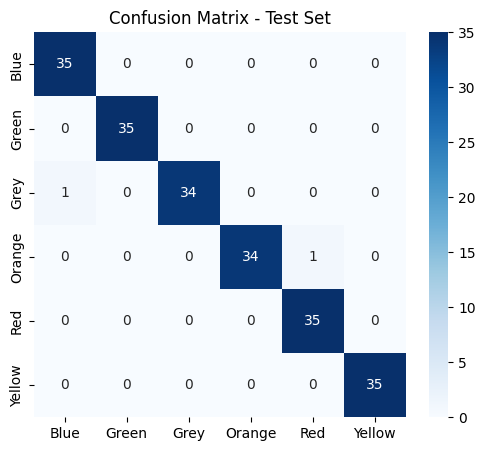

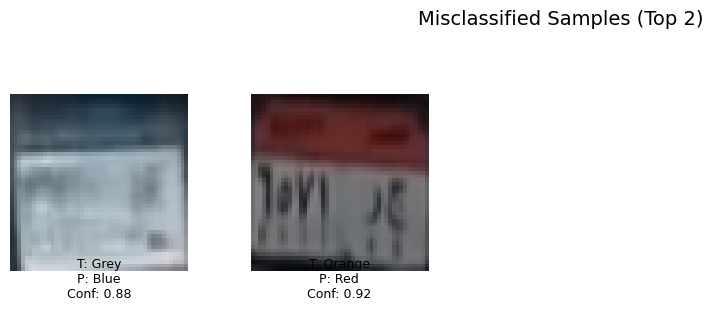


Evaluating model: /kaggle/working/models/best_SimpleCNN_fold2.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       0.97      1.00      0.99        35
       Green       1.00      1.00      1.00        35
        Grey       1.00      0.97      0.99        35
      Orange       1.00      0.91      0.96        35
         Red       0.92      1.00      0.96        35
      Yellow       1.00      1.00      1.00        35

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210



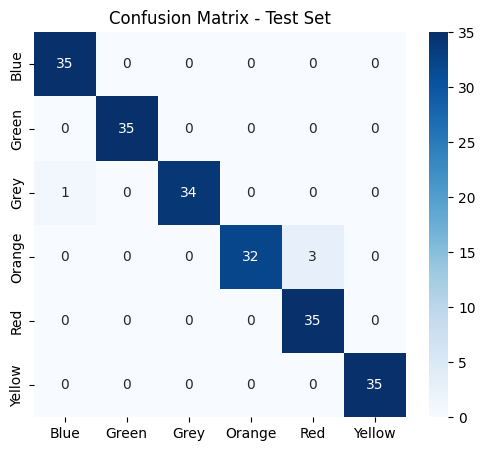

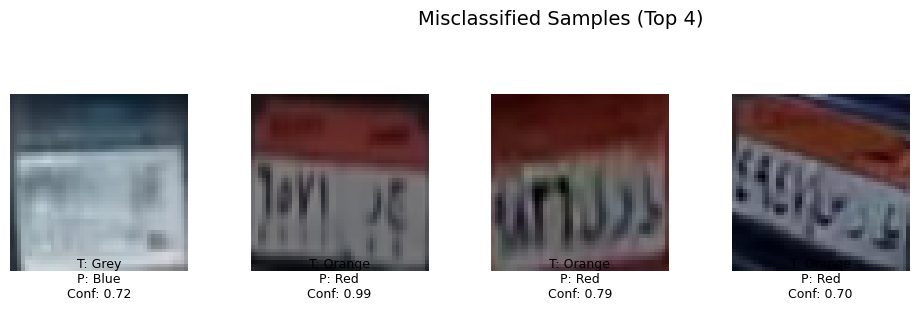


Evaluating model: /kaggle/working/models/best_SimpleCNN_fold3.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       1.00      1.00      1.00        35
       Green       1.00      1.00      1.00        35
        Grey       1.00      1.00      1.00        35
      Orange       1.00      1.00      1.00        35
         Red       1.00      1.00      1.00        35
      Yellow       1.00      1.00      1.00        35

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



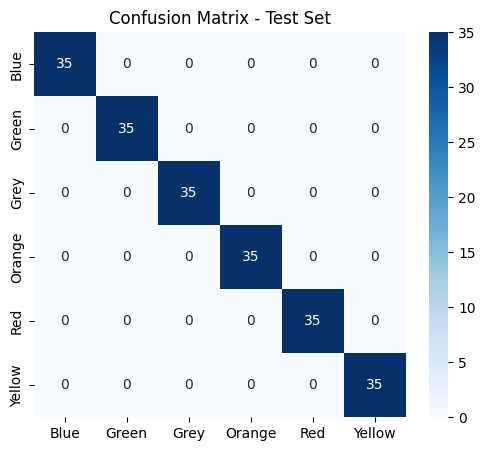

<Figure size 1500x600 with 0 Axes>


Evaluating model: /kaggle/working/models/best_SimpleCNN_fold4.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       0.95      1.00      0.97        35
       Green       1.00      1.00      1.00        35
        Grey       1.00      0.94      0.97        35
      Orange       1.00      0.97      0.99        35
         Red       0.97      1.00      0.99        35
      Yellow       1.00      1.00      1.00        35

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



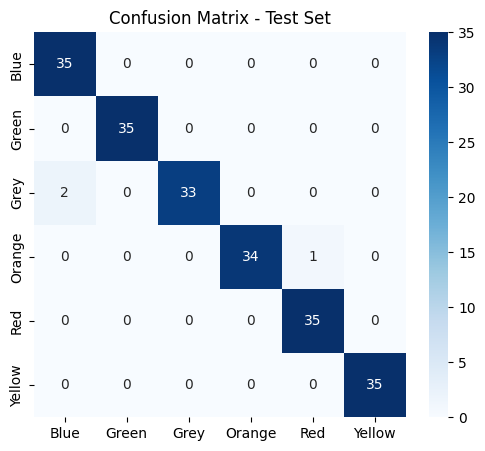

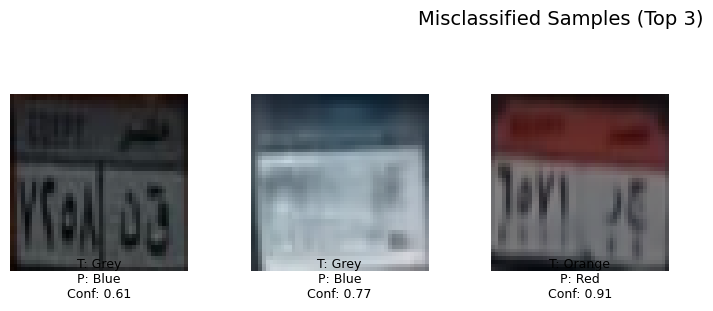


Evaluating model: /kaggle/working/models/best_SimpleCNN_fold5.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       1.00      1.00      1.00        35
       Green       1.00      1.00      1.00        35
        Grey       0.97      1.00      0.99        35
      Orange       0.97      1.00      0.99        35
         Red       1.00      1.00      1.00        35
      Yellow       1.00      0.94      0.97        35

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



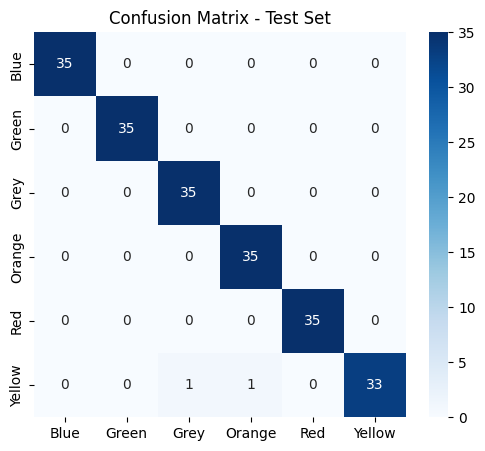

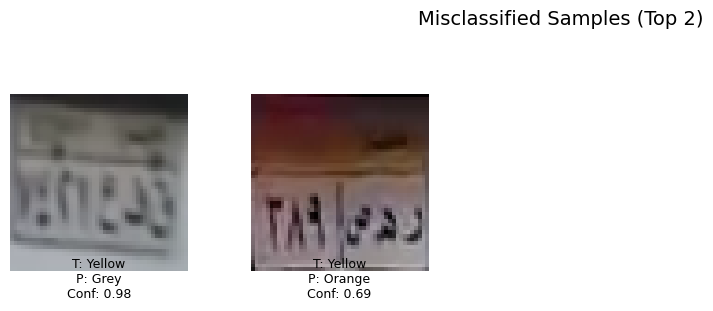

In [66]:
all_model_paths = [
    # SimpleCNN
    "/kaggle/working/models/best_SimpleCNN_fold1.pth",
    "/kaggle/working/models/best_SimpleCNN_fold2.pth",
    "/kaggle/working/models/best_SimpleCNN_fold3.pth",
    "/kaggle/working/models/best_SimpleCNN_fold4.pth",
    "/kaggle/working/models/best_SimpleCNN_fold5.pth",
]

for model_path in all_model_paths:
    if "SimpleCNN" in model_path:
        model_class = SimpleCNN
    elif "MobileNet" in model_path:
        model_class = MobileNet48
    elif "EfficientNet" in model_path:
        model_class = EfficientNet48
    else:
        continue

    print(f"\nEvaluating model: {model_path}")
    y_true, y_pred, wrong_images, wrong_preds, true_labels, conf_scores = evaluate_model(model_class, model_path, test_dataset)
    plot_misclassified(wrong_images, wrong_preds, true_labels, conf_scores, class_names)

## MobileNet

In [46]:
def MobileNet48(num_classes):
    model = models.mobilenet_v2(weights=None)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model

In [48]:
fold_models_mn = kfold_train(MobileNet48, "MobileNet", train_dataset, train_labels, n_classes)


==================== Fold 1/5 ====================
Epoch 01/50 - Train Loss: 0.9440 | Val Loss: 0.3217 | Time: 11.2s
Epoch 02/50 - Train Loss: 0.4186 | Val Loss: 0.2499 | Time: 11.1s
Epoch 03/50 - Train Loss: 0.3239 | Val Loss: 0.1183 | Time: 11.8s
Epoch 04/50 - Train Loss: 0.2922 | Val Loss: 0.1406 | Time: 10.6s
Epoch 05/50 - Train Loss: 0.2057 | Val Loss: 0.1416 | Time: 10.6s
Epoch 06/50 - Train Loss: 0.2076 | Val Loss: 0.1904 | Time: 11.3s
Epoch 07/50 - Train Loss: 0.1521 | Val Loss: 0.1797 | Time: 10.9s
Epoch 08/50 - Train Loss: 0.1966 | Val Loss: 0.2063 | Time: 10.6s
Early stopping at epoch 8
Fold 1 finished in 1.47 min, best val loss: 0.1183

==================== Fold 2/5 ====================
Epoch 01/50 - Train Loss: 1.1704 | Val Loss: 0.7200 | Time: 10.7s
Epoch 02/50 - Train Loss: 0.6213 | Val Loss: 0.3467 | Time: 10.7s
Epoch 03/50 - Train Loss: 0.4070 | Val Loss: 0.1595 | Time: 11.2s
Epoch 04/50 - Train Loss: 0.2732 | Val Loss: 0.1096 | Time: 10.9s
Epoch 05/50 - Train Loss: 0


Evaluating model: /kaggle/working/models/best_MobileNet_fold1.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       1.00      0.97      0.99        35
       Green       0.78      1.00      0.88        35
        Grey       0.89      0.71      0.79        35
      Orange       0.97      0.97      0.97        35
         Red       0.94      0.97      0.96        35
      Yellow       0.88      0.80      0.84        35

    accuracy                           0.90       210
   macro avg       0.91      0.90      0.90       210
weighted avg       0.91      0.90      0.90       210



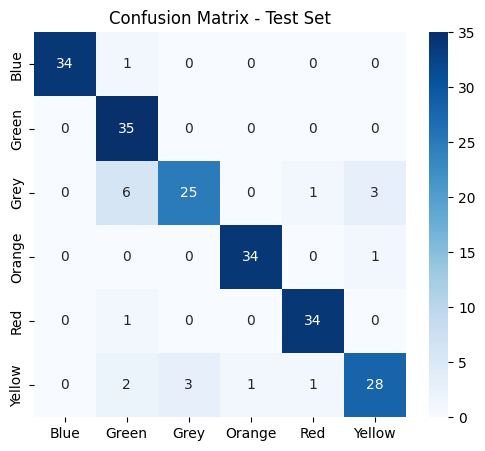

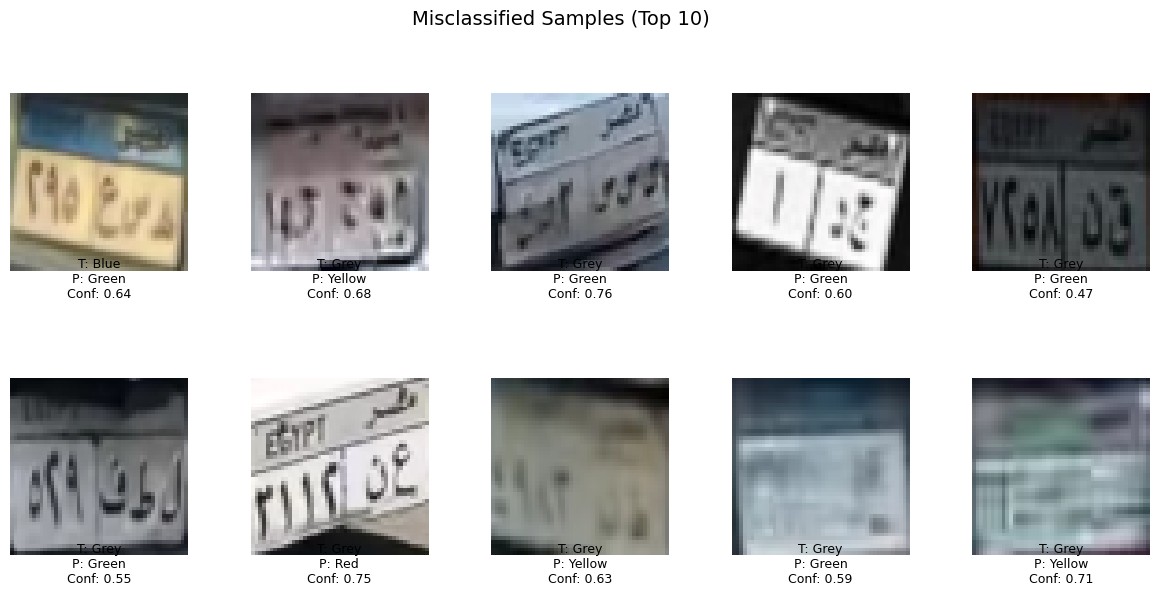


Evaluating model: /kaggle/working/models/best_MobileNet_fold2.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       0.97      1.00      0.99        35
       Green       1.00      0.94      0.97        35
        Grey       0.89      0.97      0.93        35
      Orange       0.97      0.89      0.93        35
         Red       0.92      0.94      0.93        35
      Yellow       0.91      0.91      0.91        35

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210



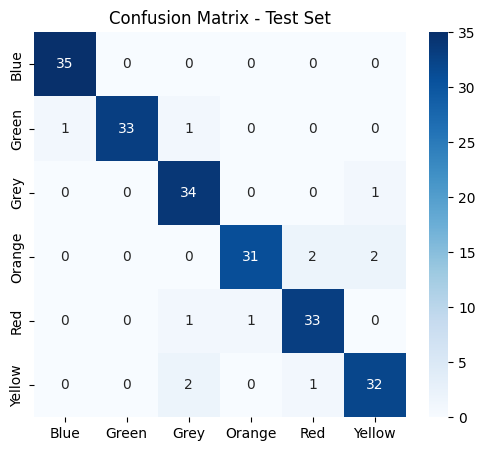

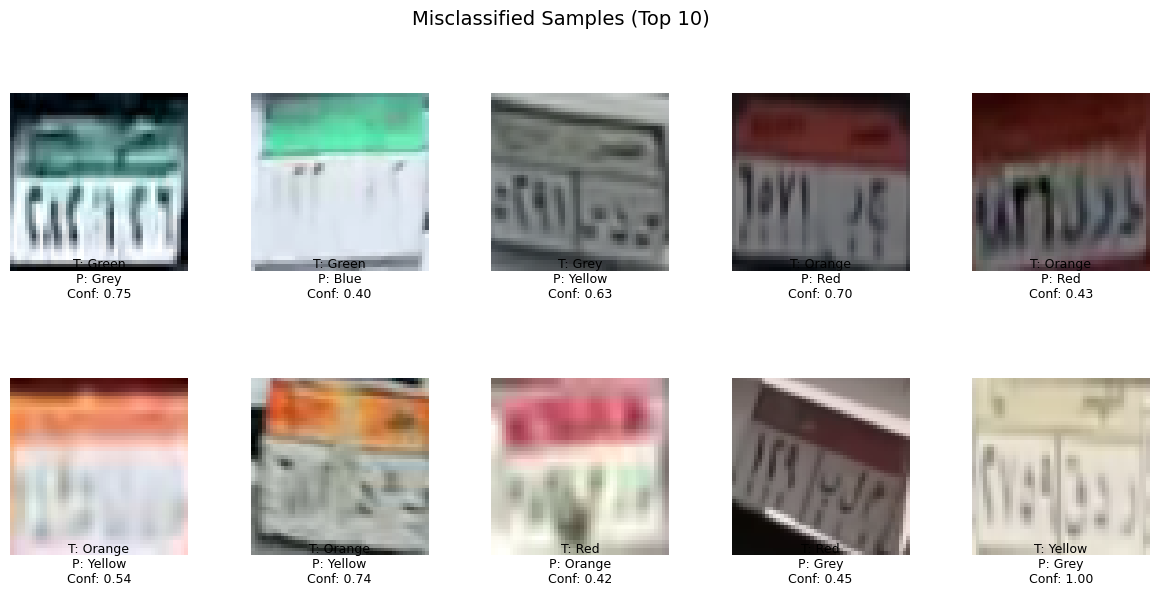


Evaluating model: /kaggle/working/models/best_MobileNet_fold3.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       0.94      0.97      0.96        35
       Green       1.00      1.00      1.00        35
        Grey       0.86      0.91      0.89        35
      Orange       1.00      0.97      0.99        35
         Red       1.00      0.97      0.99        35
      Yellow       0.94      0.91      0.93        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



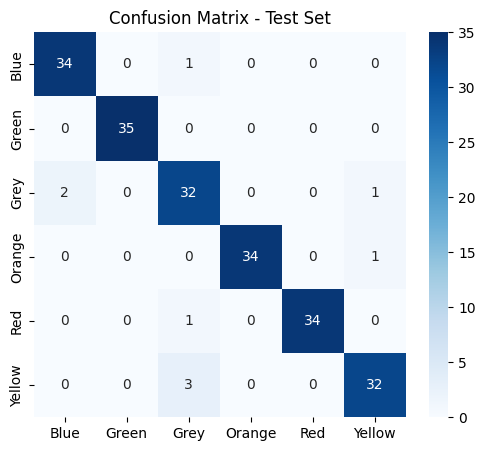

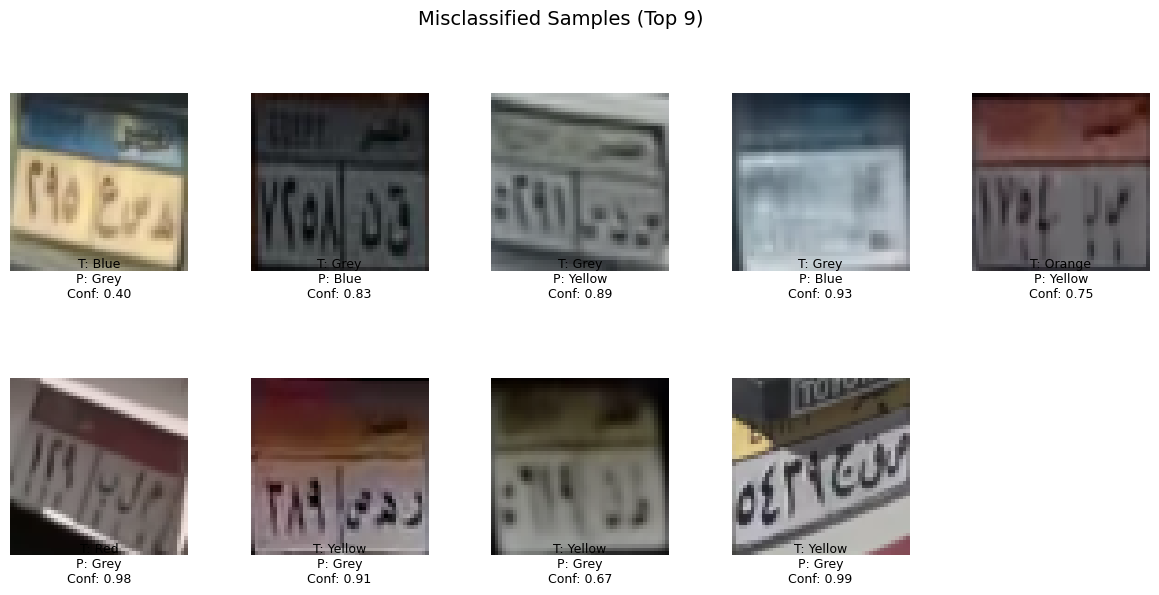


Evaluating model: /kaggle/working/models/best_MobileNet_fold4.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       0.97      1.00      0.99        35
       Green       0.97      0.97      0.97        35
        Grey       1.00      0.89      0.94        35
      Orange       1.00      0.94      0.97        35
         Red       0.95      1.00      0.97        35
      Yellow       0.89      0.97      0.93        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



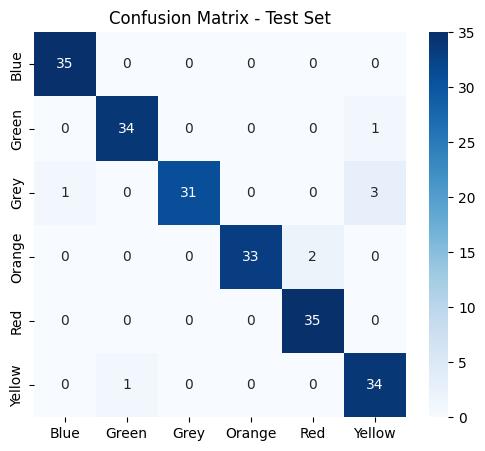

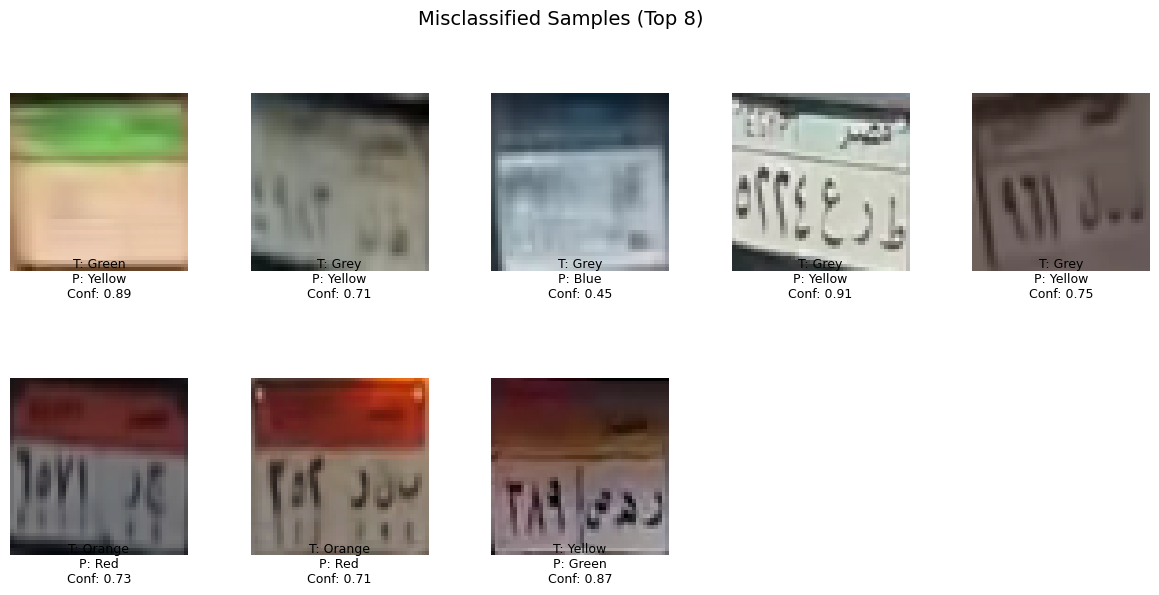


Evaluating model: /kaggle/working/models/best_MobileNet_fold5.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       0.95      1.00      0.97        35
       Green       1.00      1.00      1.00        35
        Grey       1.00      0.89      0.94        35
      Orange       0.97      0.97      0.97        35
         Red       1.00      1.00      1.00        35
      Yellow       0.92      0.97      0.94        35

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



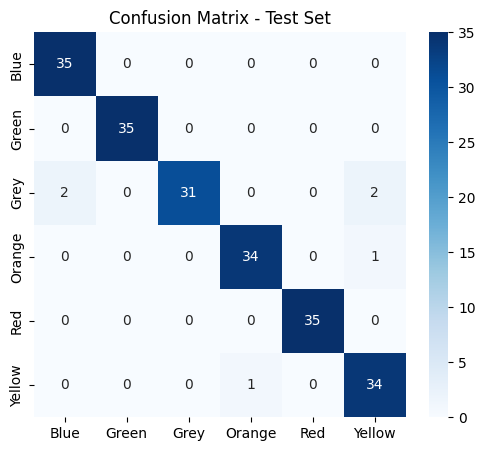

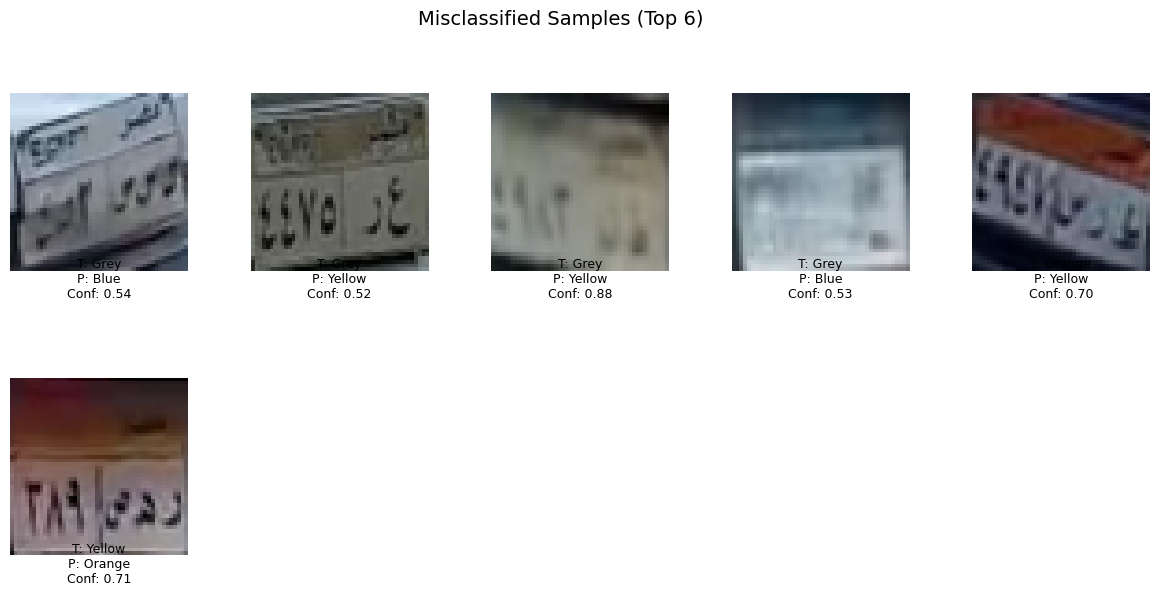

In [67]:
all_model_paths = [
    # MobileNet
    "/kaggle/working/models/best_MobileNet_fold1.pth",
    "/kaggle/working/models/best_MobileNet_fold2.pth",
    "/kaggle/working/models/best_MobileNet_fold3.pth",
    "/kaggle/working/models/best_MobileNet_fold4.pth",
    "/kaggle/working/models/best_MobileNet_fold5.pth",
]

for model_path in all_model_paths:
    if "SimpleCNN" in model_path:
        model_class = SimpleCNN
    elif "MobileNet" in model_path:
        model_class = MobileNet48
    elif "EfficientNet" in model_path:
        model_class = EfficientNet48
    else:
        continue  
    print(f"\nEvaluating model: {model_path}")
    y_true, y_pred, wrong_images, wrong_preds, true_labels, conf_scores = evaluate_model(model_class, model_path, test_dataset)
    plot_misclassified(wrong_images, wrong_preds, true_labels, conf_scores, class_names)

## EfficientNet

In [50]:
def EfficientNet48(num_classes):
    model = models.efficientnet_b0(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

In [51]:
fold_models_en = kfold_train(EfficientNet48, "EfficientNet", train_dataset, train_labels, n_classes)


==================== Fold 1/5 ====================
Epoch 01/50 - Train Loss: 1.0003 | Val Loss: 0.3223 | Time: 12.5s
Epoch 02/50 - Train Loss: 0.4020 | Val Loss: 0.6745 | Time: 13.0s
Epoch 03/50 - Train Loss: 0.3483 | Val Loss: 0.1366 | Time: 13.3s
Epoch 04/50 - Train Loss: 0.2675 | Val Loss: 0.1453 | Time: 12.6s
Epoch 05/50 - Train Loss: 0.1754 | Val Loss: 0.2825 | Time: 12.6s
Epoch 06/50 - Train Loss: 0.1381 | Val Loss: 0.0774 | Time: 13.0s
Epoch 07/50 - Train Loss: 0.1259 | Val Loss: 0.0506 | Time: 13.3s
Epoch 08/50 - Train Loss: 0.1092 | Val Loss: 0.1854 | Time: 13.3s
Epoch 09/50 - Train Loss: 0.0902 | Val Loss: 0.0561 | Time: 12.9s
Epoch 10/50 - Train Loss: 0.0805 | Val Loss: 0.0829 | Time: 12.9s
Epoch 11/50 - Train Loss: 0.1607 | Val Loss: 0.0554 | Time: 13.1s
Epoch 12/50 - Train Loss: 0.0945 | Val Loss: 0.0626 | Time: 13.3s
Early stopping at epoch 12
Fold 1 finished in 2.60 min, best val loss: 0.0506

==================== Fold 2/5 ====================
Epoch 01/50 - Train Loss: 


Evaluating model: /kaggle/working/models/best_EfficientNet_fold1.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       1.00      1.00      1.00        35
       Green       1.00      1.00      1.00        35
        Grey       0.97      1.00      0.99        35
      Orange       0.92      0.97      0.94        35
         Red       0.97      1.00      0.99        35
      Yellow       1.00      0.89      0.94        35

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210



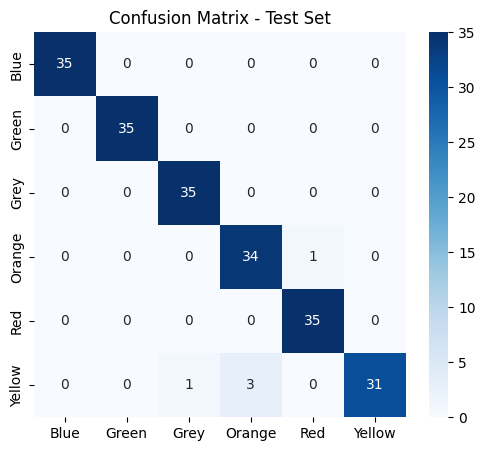

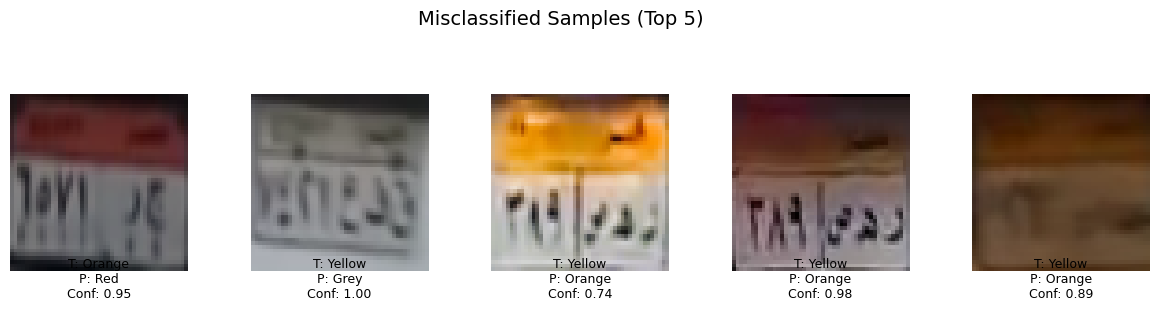


Evaluating model: /kaggle/working/models/best_EfficientNet_fold2.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       1.00      1.00      1.00        35
       Green       1.00      1.00      1.00        35
        Grey       0.95      1.00      0.97        35
      Orange       0.97      1.00      0.99        35
         Red       1.00      0.97      0.99        35
      Yellow       1.00      0.94      0.97        35

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



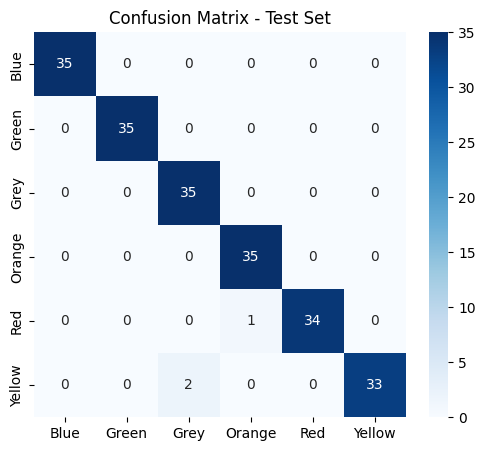

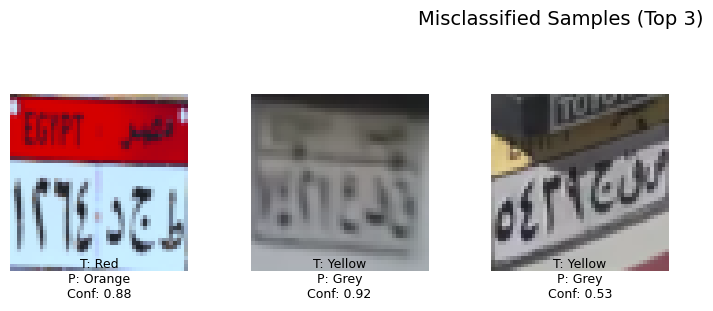


Evaluating model: /kaggle/working/models/best_EfficientNet_fold3.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       1.00      1.00      1.00        35
       Green       1.00      1.00      1.00        35
        Grey       1.00      0.97      0.99        35
      Orange       1.00      0.94      0.97        35
         Red       1.00      1.00      1.00        35
      Yellow       0.92      1.00      0.96        35

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



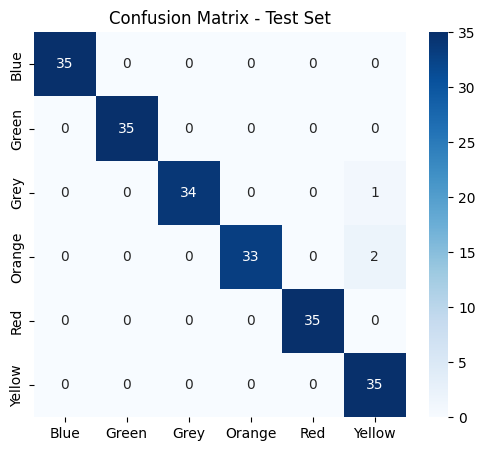

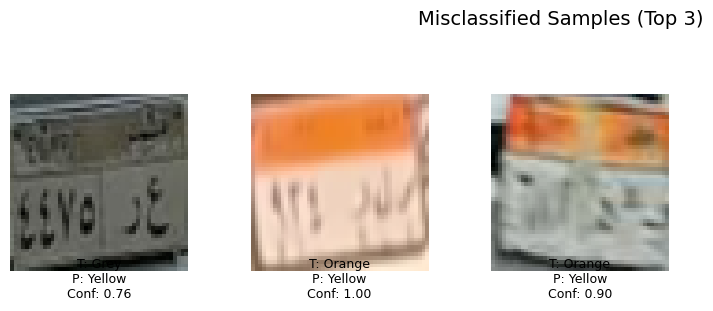


Evaluating model: /kaggle/working/models/best_EfficientNet_fold4.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       1.00      1.00      1.00        35
       Green       1.00      1.00      1.00        35
        Grey       0.94      0.97      0.96        35
      Orange       0.97      1.00      0.99        35
         Red       1.00      0.97      0.99        35
      Yellow       0.97      0.94      0.96        35

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210



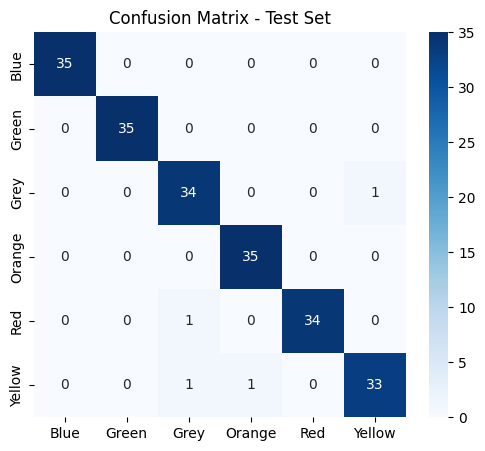

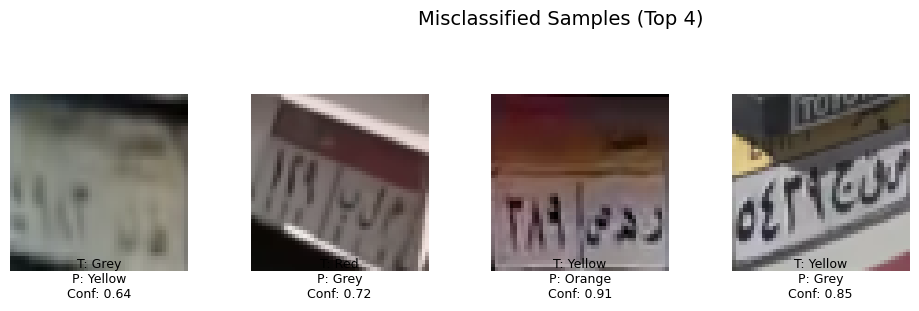


Evaluating model: /kaggle/working/models/best_EfficientNet_fold5.pth

Classification Report on Test Set:
              precision    recall  f1-score   support

        Blue       1.00      0.94      0.97        35
       Green       1.00      0.97      0.99        35
        Grey       0.90      1.00      0.95        35
      Orange       0.92      1.00      0.96        35
         Red       1.00      0.97      0.99        35
      Yellow       1.00      0.91      0.96        35

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



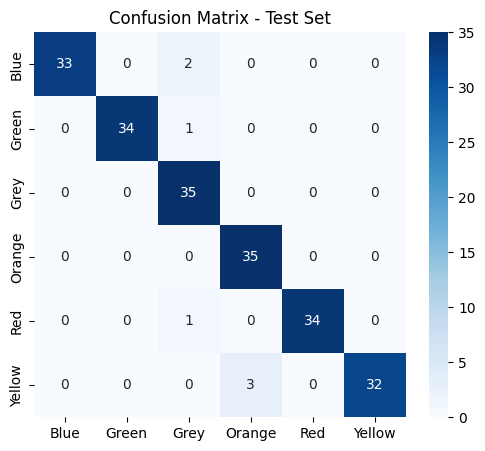

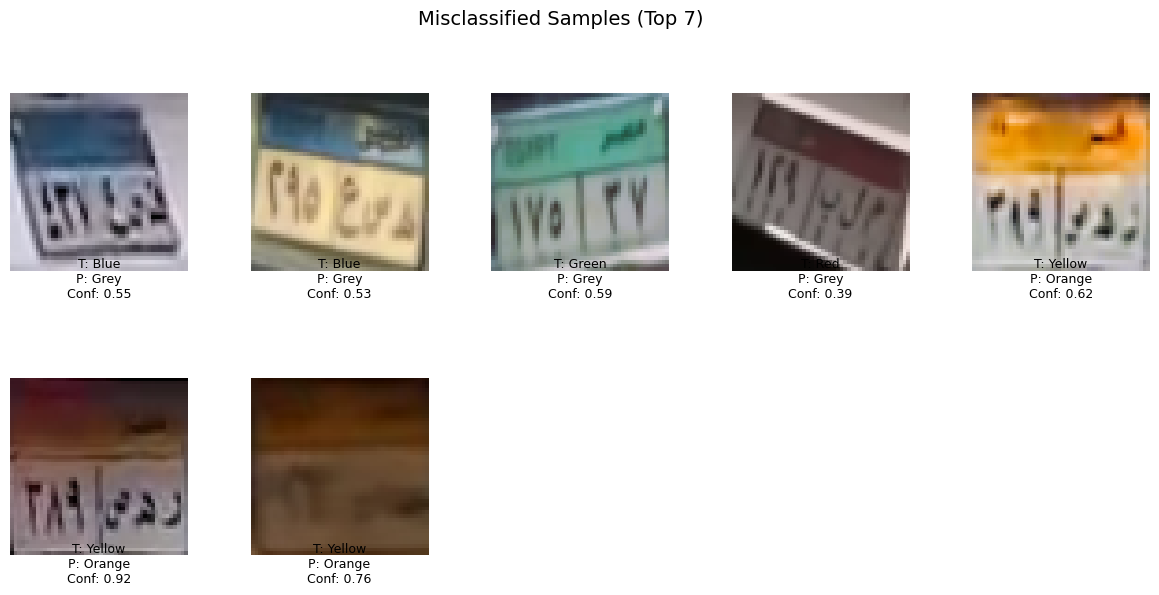

In [68]:
all_model_paths = [
    # EfficientNet
    "/kaggle/working/models/best_EfficientNet_fold1.pth",
    "/kaggle/working/models/best_EfficientNet_fold2.pth",
    "/kaggle/working/models/best_EfficientNet_fold3.pth",
    "/kaggle/working/models/best_EfficientNet_fold4.pth",
    "/kaggle/working/models/best_EfficientNet_fold5.pth",
]

for model_path in all_model_paths:
    if "SimpleCNN" in model_path:
        model_class = SimpleCNN
    elif "MobileNet" in model_path:
        model_class = MobileNet48
    elif "EfficientNet" in model_path:
        model_class = EfficientNet48
    else:
        continue

    print(f"\nEvaluating model: {model_path}")
    y_true, y_pred, wrong_images, wrong_preds, true_labels, conf_scores = evaluate_model(model_class, model_path, test_dataset)
    plot_misclassified(wrong_images, wrong_preds, true_labels, conf_scores, class_names)

# Inference

In [57]:
from torch.utils.data import DataLoader
import pandas as pd

In [64]:
import os
import torch
import pandas as pd
from torch.utils.data import DataLoader

COLOR_MAP = {
    "blue": "private",
    "orange": "taxi",
    "red": "commercial",
    "grey": "public",
    "green": "diplomatic",
    "yellow": "tourist&temporary"
}

def inference_testset(model_class, model_path, test_dataset, device=DEVICE, csv_path=None):
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    class_names = test_dataset.classes
    n_classes = len(class_names)

    model = model_class(num_classes=n_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    results = []

    with torch.no_grad():
        for idx, (img_tensor, _) in enumerate(test_loader):
            img_tensor = img_tensor.to(device)
            outputs = model(img_tensor)
            probs = torch.softmax(outputs, dim=1)
            conf, pred = torch.max(probs, 1)
            
            pred_class_name = class_names[pred.item()].strip().lower()
            mapped_type = COLOR_MAP.get(pred_class_name.lower(), pred_class_name)

            img_path = test_dataset.imgs[idx][0] 
            results.append({
                "img_name": os.path.basename(img_path),
                "mapped_type": mapped_type,
                "confidence": conf.item()
            })

    df = pd.DataFrame(results)

    if csv_path is not None:
        df.to_csv(csv_path, index=False)
        print(f"Saved predictions to {csv_path}")

    return df

In [69]:
df_test_pred = inference_testset(
    SimpleCNN,
    "/kaggle/working/models/best_SimpleCNN_fold3.pth",
    test_dataset,
    csv_path="/kaggle/working/test_predictions.csv"
)
df_test_pred.head(10)

Saved predictions to /kaggle/working/test_predictions.csv


,img_name,mapped_type,confidence
0,Screenshot 2025-10-08 093310.png,private,1.0
1,Screenshot 2025-10-08 093316.png,private,1.0
2,Screenshot 2025-10-08 095650.png,private,1.0
3,Screenshot 2025-10-08 095746.png,private,1.0
4,Screenshot 2025-10-08 095753.png,private,1.0
5,Screenshot 2025-10-08 104005.png,private,1.0
6,Screenshot 2025-10-08 104120.png,private,1.0
7,Screenshot 2025-10-08 104326.png,private,1.0
8,Screenshot 2025-10-08 105155.png,private,1.0
9,Screenshot 2025-10-08 113036.png,private,1.0
